In [1]:
dataset_name = "ambient_temperature_system_failure"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 128

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '1H', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '1H', data, method="linear")

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1H", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2013-12-22 20:00:00",
                      "2014-04-13 09:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2013-07-04 00:00:00
End date:  2014-05-28 15:00:00
Missing time stamps: 
 DatetimeIndex(['2013-07-28 02:00:00', '2013-07-28 05:00:00',
               '2013-07-28 06:00:00', '2013-07-28 07:00:00',
               '2013-07-28 08:00:00', '2013-07-28 09:00:00',
               '2013-07-28 10:00:00', '2013-07-28 11:00:00',
               '2013-07-28 12:00:00', '2013-07-28 13:00:00',
               ...
               '2014-04-10 05:00:00', '2014-04-10 06:00:00',
               '2014-04-10 07:00:00', '2014-04-10 08:00:00',
               '2014-04-10 09:00:00', '2014-04-10 10:00:00',
               '2014-04-10 11:00:00', '2014-04-10 12:00:00',
               '2014-04-10 13:00:00', '2014-04-10 14:00:00'],
              dtype='datetime64[ns]', length=621, freq=None)
Fill Missing Time Steps with Interpolation
Length:  7888
Time step size:  1H
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [4124, 6801]


# SARIMA: using own params

# trend and seasonality -> try HWES

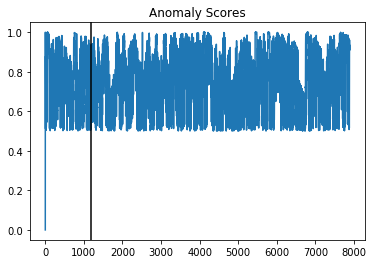

Time:  3.9547016620635986
RMSE:  2.3692652560219587


['anomaly_scores/SARIMA_guide/ambient_temperature_system_failure']

In [4]:
save_path = "anomaly_scores/SARIMA_guide/" + dataset_name
output_dict = ad.hwes(gaussian_window_size=gaussian_window_size,slen=24, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# SARIMA: using autoarima

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 24); AIC=3069.389, BIC=3109.988, Fit time=104.691 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=3305.024, BIC=3315.174, Fit time=0.228 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=3167.585, BIC=3187.885, Fit time=4.667 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=3187.045, BIC=3207.345, Fit time=5.602 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 24); AIC=3138.576, BIC=3174.101, Fit time=36.135 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 24); AIC=3065.338, BIC=3111.012, Fit time=254.653 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 0, 24); AIC=3131.673, BIC=3172.273, Fit time=109.616 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 2, 24); AIC=3072.385, BIC=3123.135, Fit time=314.677 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 24); AIC=3133.443, BIC=3168.968, Fit time=9.706 seconds
Fit ARIMA: order=(1

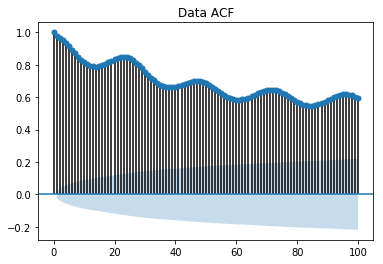

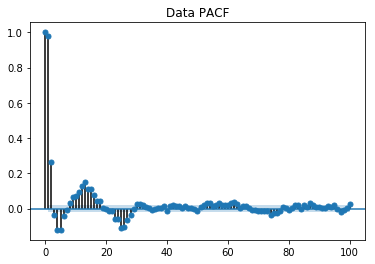

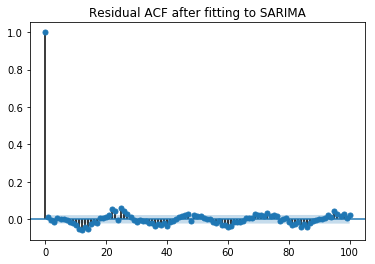

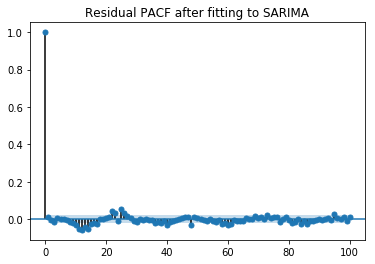

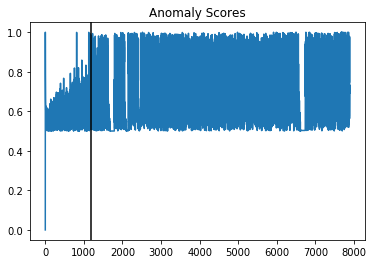

Time:  2015.4328525066376
RMSE:  1.140350289667713


['anomaly_scores/SARIMA_auto/ambient_temperature_system_failure']

In [5]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,autoarima=True, autoarima_season=True, s=24, plot_acf=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# FB Prophet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


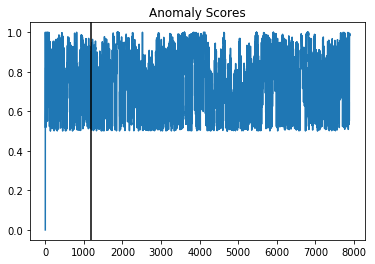

Time:  27.155345916748047
RMSE:  2.066109665540239


['anomaly_scores/Prophet/ambient_temperature_system_failure']

In [6]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size,periods=0, daily_seasonality=True, interval_width=.999, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# RNN

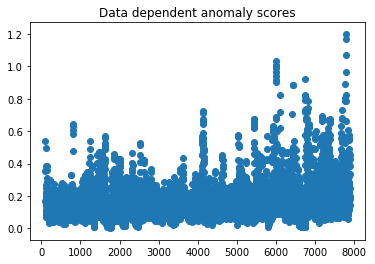

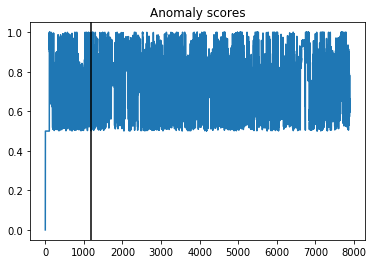

Time:  482.41489911079407


['anomaly_scores/RNN/ambient_temperature_system_failure']

In [4]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=5, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

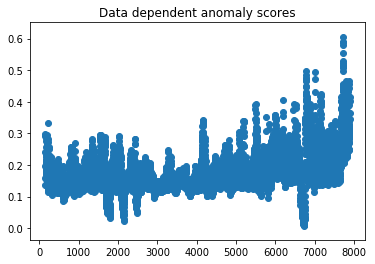

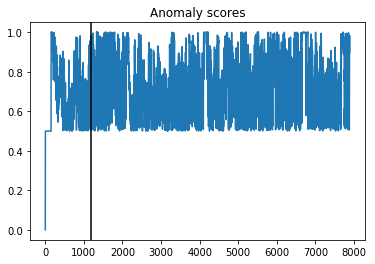

Time:  394.54091143608093


['anomaly_scores/RNN/ambient_temperature_system_failure']

In [7]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=50, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

In [8]:
save_path = "anomaly_scores/Twitter/" + dataset_name
output_dict = ad.twitterad(period=24, max_anoms=2/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

R twitterad completed: True
Time:  0.5184962749481201


['anomaly_scores/Twitter/ambient_temperature_system_failure']

# HTM

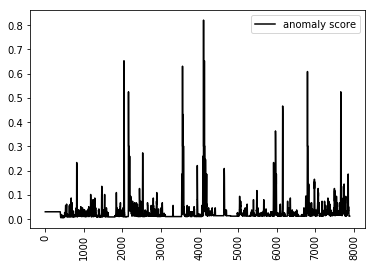

Time:  91


['anomaly_scores/HTM/ambient_temperature_system_failure']

In [9]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"

htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", 91)
output_dict = {"Anomaly Scores": anomaly_scores, "Time": 91}
joblib.dump(output_dict, save_path)

# Donut

Trainable Parameters              (58,150 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (120,)         120
donut/p_x_given_z/x_mean/kernel  (100, 120)  12,000
donut/p_x_given_z/x_std/bias     (120,)         120
donut/p_x_given_z/x_std/kernel   (100, 120)  12,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (120, 100)  12,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 20, ETA 16.74s] Learning rate decreased to 

INFO:tensorflow:Restoring parameters from /tmp/tmpmjm_61q1/variables.dat-500


[Epoch 250/256, Step 500, ETA 0.1478s] step time: 0.01007s (±0.03784s); valid time: 0.3805s; loss: 126.923 (±4.70771); valid loss: 127.85 (*)
[Epoch 250/256, Step 500, ETA 0.1478s] Learning rate decreased to 7.525434581650002e-07


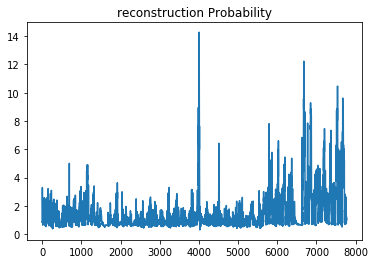

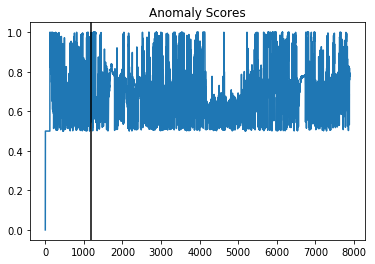

Time:  30.814159154891968


['anomaly_scores/Donut/ambient_temperature_system_failure']

In [10]:
save_path = "anomaly_scores/Donut/" + dataset_name
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

R stlplus completed:  no missing True


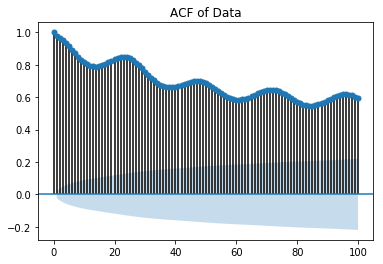

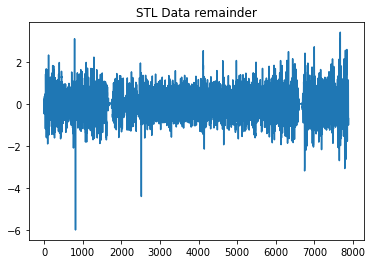

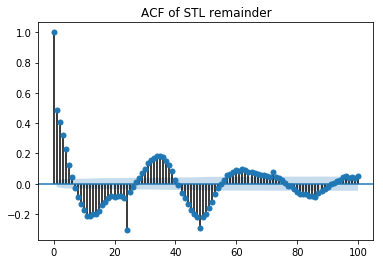

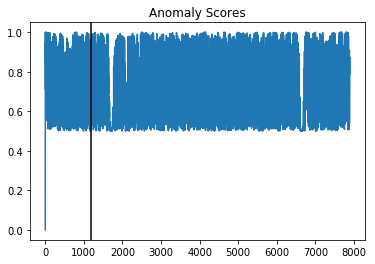

Time:  1.7435128688812256


['anomaly_scores/stl/ambient_temperature_system_failure']

In [12]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size,n_periods=24, swindow=7, outer=1, fill_option="linear", plot_resid=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# windowed gaussian

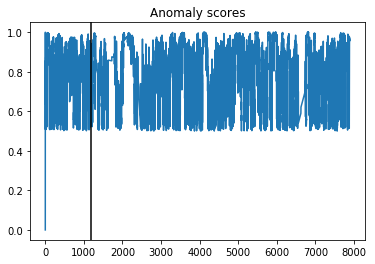

Time:  0.29757237434387207


['anomaly_scores/windowed_gaussian/ambient_temperature_system_failure']

In [13]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name
output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size,plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

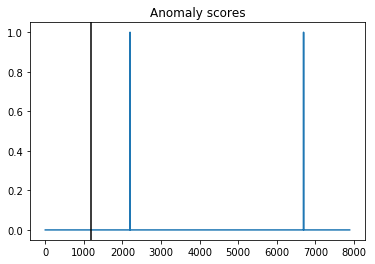

Time:  33.604952335357666


['anomaly_scores/hotsax/ambient_temperature_system_failure']

In [14]:
save_path = "anomaly_scores/hotsax/" + dataset_name
output_dict = ad.hotsax(win_size=50, num_discords=2,
               a_size=3, paa_size=3, z_threshold=0.01,
               plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)